In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
path = '/Users/dangloan/Documents/learning_analytics/project/'

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

## Read data

In [4]:
df = pd.read_csv(path + '3_data/clothing_review/Womens Clothing E-Commerce Reviews.csv')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.columns =['Clothing_ID','Age','Title','Review_Text','Rating',
             'Recommended_IND','Positive_Feedback_Count',
             'Division_Name','Department_Name','Class_Name']

In [7]:
len(df)

23486

In [6]:
#Clean data - Remove duplicates
df[df.duplicated(keep=False)].sort_values(by='Clothing_ID')
df.drop_duplicates(keep='first',inplace=True)

### Apply topics to Business Analysis:
Question: What are top purchase (top 20%) and negatively reviewed (Rating average (mean) < 3). Analyze what issues with these products, and send reccommendation to retailers on how they can improve their product.

I'm going to label the topic issues-wise (rather than item-and-issue-wise as the above):

In [192]:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1[a1['Rating']<3]
a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a4 = a3.sort_values(['Rating','Age'],ascending=[True,False])
a4.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

,Clothing_ID,Rating,Age
973,973,1.0,2
759,759,1.0,1
118,118,1.0,1
812,812,1.0,1
814,814,1.0,1


int64
object


Text(0.5, 0, 'Count_ProductID')

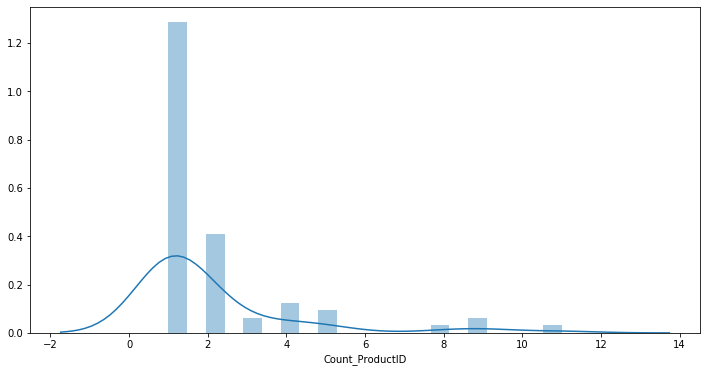

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
# a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [ ]:
a4.describe()

I found out that there should be a method to choose which products need to be prioritized for improvement. I thought of:

- Method 1: Choose top 80% received largest number of reviews (nlargest_count) (dataset 1), then get products with average rating < 3.
This is unreasonable because the rating_mean of dataset 1 is around 4.19 (std ~ 0.3). There really is only one product from dataset 1 that has average rating <3.


- Method 2: Choose products with average rating < 3, then get top 80% received largest number of reviews (nlargest_count). This is also unfeaseable because the final selected products still have very small number of reviews (largely, from 1 to 2 reviews).

SO, we need another method.

In [194]:
## Method 1:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a3 = a2[a2['Rating'] <3]
print(a3.describe())
print(a2.describe())

       Clothing_ID    Rating   Age
count          1.0  1.000000   1.0
mean         229.0  2.181818  11.0
std            NaN       NaN   NaN
min          229.0  2.181818  11.0
25%          229.0  2.181818  11.0
50%          229.0  2.181818  11.0
75%          229.0  2.181818  11.0
max          229.0  2.181818  11.0
       Clothing_ID      Rating          Age
count   241.000000  241.000000   241.000000
mean    878.107884    4.163741    87.991701
std     252.781206    0.349924   133.802466
min      90.000000    2.181818     9.000000
25%     840.000000    3.962963    16.000000
50%     938.000000    4.192015    37.000000
75%    1052.000000    4.400000    96.000000
max    1203.000000    4.809524  1021.000000


In [195]:
## Method 2:
b0 = df[df['Rating'] <=2]
b1 = b0.groupby('Clothing_ID').agg({'Rating': ['count','mean','median']}).reset_index()
b1.columns = ['Clothing_ID','Rating_count','Rating_mean','Rating_median']
b1.describe()

,Clothing_ID,Rating_count,Rating_mean,Rating_median
count,391.000000,391.000000,391.000000,391.000000
mean,766.388747,6.156010,1.642581,1.707161
std,325.546259,10.998774,0.364128,0.425832
min,1.000000,1.000000,1.000000,1.000000
25%,551.000000,1.000000,1.500000,1.500000
50%,879.000000,2.000000,1.703704,2.000000
75%,1020.500000,6.000000,2.000000,2.000000
max,1195.000000,92.000000,2.000000,2.000000


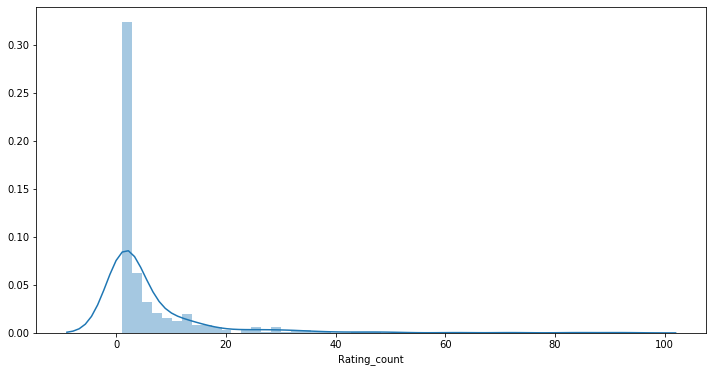

In [196]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b1['Rating_count'])

In [197]:
b2 = b1[b1['Rating_count'] >=6]

What we want is to select products receiving a certain number of negative reviews. These number of reviews should be large enough to show that retailers needs to care for improvement, but not some personal negative reviews (a very small number of negative reviews in comparison with the total number of reviews/total number of purchases).

On average, a product would receive ~ 6 (mean of Rating_count 6.15) negative reviews (Rating <=2).

In [198]:
b2.describe()

,Clothing_ID,Rating_count,Rating_mean,Rating_median
count,106.000000,106.000000,106.000000,106.000000
mean,955.735849,18.075472,1.649835,1.849057
std,101.333518,15.784681,0.155821,0.346203
min,818.000000,6.000000,1.272727,1.000000
25%,864.250000,8.250000,1.556548,2.000000
50%,940.500000,12.000000,1.666667,2.000000
75%,1067.500000,22.500000,1.738558,2.000000
max,1121.000000,92.000000,2.000000,2.000000


In [199]:
c1 = df[df['Clothing_ID'].isin(b2['Clothing_ID'])]
c2 = c1.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
# a2 = a1[a1['Rating']<3]
# a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
c3 = c2.sort_values(['Rating','Age'],ascending=[True,False])
c3.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

,Clothing_ID,Rating,Age
56,946,2.444444,9
49,929,3.200000,20
57,948,3.200000,10
67,1016,3.333333,24
75,1055,3.360000,25


int64
object


Text(0.5, 0, 'Count_ProductID')

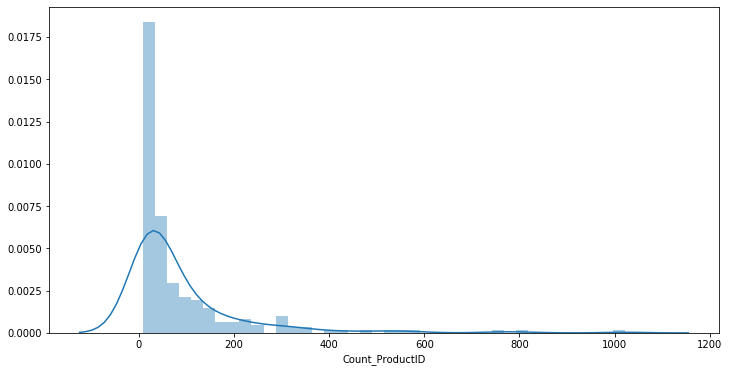

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [330]:
e = df.groupby('Clothing_ID')['Rating'].agg({'count','mean'}).reset_index()
e.columns =['Clothing_ID','R_count','R_mean']

print(e.describe())
print(e.R_count.quantile(0.9))

       Clothing_ID      R_count       R_mean
count   1206.00000  1206.000000  1206.000000
mean     602.50000    19.456882     4.198509
std      348.28652    68.868479     0.849257
min        0.00000     1.000000     1.000000
25%      301.25000     1.000000     4.000000
50%      602.50000     2.000000     4.333333
75%      903.75000     6.750000     5.000000
max     1205.00000  1021.000000     5.000000
36.5


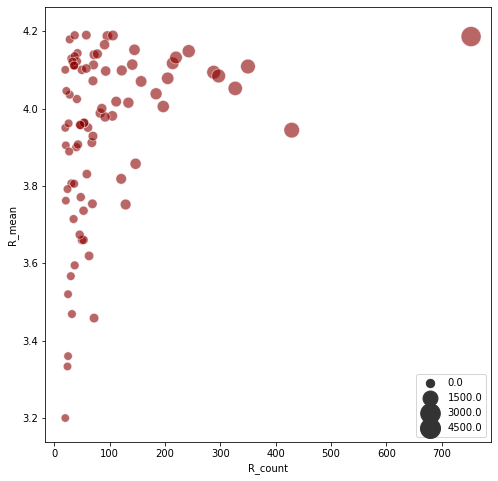

In [331]:
import seaborn as sns
e1 = e[(e['R_count']>19.5) & (e['R_mean']<4.19)]
# e1 = copy.deepcopy(e)
plt.figure(figsize=(8,8))
sns.scatterplot(e1['R_count'], e1['R_mean'], size = e1['R_count']*e1['R_mean'],
                sizes=(70, 400), color='darkred', alpha=0.6)

In [205]:
# e1[e1['R_mean'] <3.7]
e1[e1['R_count'] >350]

,Clothing_ID,R_count,R_mean
868,868,429,3.944056
1094,1094,753,4.185923


In [ ]:
z['Clothing_ID'].nunique()

In [206]:
# test = z[z['Clothing_ID'] == 1084]
# test = z[z['Clothing_ID'] == 838]
test = y[y['Clothing_ID'] == 868]

In [208]:
test.groupby(['dominant_topic_theme'])['Clothing_ID'].count().reset_index()\
            .sort_values('Clothing_ID',ascending=False)

,dominant_topic_theme,Clothing_ID
5,Size/small,28
1,Color/material,23
0,Color/fabric,22
2,Fabric/fit,22
4,Shoulder/arm/length/wide/fabric,18
3,Fit/fabric/quality,15
6,Wash/dry/fit/stretch/fabric,7


In [211]:
test = y[y['Clothing_ID'] == 1094]
test.groupby('dominant_topic_theme')['Clothing_ID'].count().reset_index()\
            .sort_values('Clothing_ID',ascending=False)

,dominant_topic_theme,Clothing_ID
5,Size/small,50
1,Color/material,28
2,Fabric/fit,26
0,Color/fabric,21
3,Fit/fabric/quality,19
4,Shoulder/arm/length/wide/fabric,18
6,Wash/dry/fit/stretch/fabric,10


In [176]:
y[y['Clothing_ID'] == 868]

,Clothing_ID,Review_Text,dominant_topic,dominant_topic_perc,dominant_topic_theme,0,1,2,3,4,5
61,868,I liked the color of this top but i didn't really like the ruffled stitching around the middle. it looks like someone just tacked on the bottom half. i bought this for my daughter and she likes it. i think it is comfortable and a good top to knock around in.,5,0.608341,Fabric/fit,0.000000,0.000000,0.386691,0.000000,0.000000,0.608341
62,868,"The styling of this top is really cute. it fits perfectly on the shoulders and gets bigger at the hem for the baby doll look. my biggest complaint is the quality! it's really cheap and feels like the quality i would expect to see at a cheap retailer. it catches lint like crazy and because the hem is just a pearl edge, it curls really badly. i buy quite a bit from here and this is the worst quality item i have seen in a long time. not worth the $$ if paying full price.",6,0.520961,Fit/fabric/quality,0.142686,0.334875,0.000000,0.000000,0.000000,0.000000
63,868,"Like the other reviewer said this top is extremely wide and boxy. it must be pinned in the picture online. it's very frustrating when they do that. thank goodness i didn't pay for shipping! for reference, i'm 5'2 and 135 pounds and bought the xxs, it's going back for sure. i'm trying to lose baby weight, not trying to look pregnant!",5,0.996484,Fabric/fit,0.000000,0.000000,0.000000,0.000000,0.000000,0.996484
243,868,"I order this shirt because it looked like a shirt you could dress up or down. when i got it the shirt was really wrinkled. therefore, i knew it would have to ironed a lot. it was quite boxy and was shorter in the front then in the back. i didn't realize that this shirt was two different fabrics. overall i think this shirt would be more flattering on a woman that was petite.",5,0.676849,Fabric/fit,0.319008,0.000000,0.000000,0.000000,0.000000,0.676849
244,868,Top is very wide and flowy. i am petite with large chest so it hung from widest point and was not flattering. would be very cute with the right body shape.,5,0.601712,Fabric/fit,0.393771,0.000000,0.000000,0.000000,0.000000,0.601712
285,868,"I'm 5""0"" and weigh 105 lbs. i purchased the xxs and it was super-wide, and big all over. it looked like a pregnancy top and did not lay as nicely as shown on the model. also, not shown on the model is the front is short and the back is very long. this would work better on a taller person. i just find it odd that a xxs is still too big. the quality of the fabric and the print is good and the lace-up in the back is cute.",4,0.790883,Shoulder/arm/length/wide/fabric,0.000000,0.000000,0.000000,0.206744,0.790883,0.000000
437,868,Glad i got this on sale. it is more yellow than the photo & short. it is also heavy with a sueded interior. would have given more stars if it was less boxy & longer.,0,0.798379,Color/material,0.798379,0.195424,0.000000,0.000000,0.000000,0.000000
642,868,"I loved this color and ordered it online because i thought it would work for both casual and work days dressed up a little. ummmmm, no. it's weird and boxy and does not look at all like it does on the model. i think maybe if you have no bust whatsoever and size way down it would look okay. i'm only a 34b, weigh 110 pounds, 5'3"" and it made me look huge and awkward. this is going back!",4,0.607875,Shoulder/arm/length/wide/fabric,0.000000,0.000000,0.000000,0.388571,0.607875,0.000000
643,868,"I purchased this top on sale and was really excited about the style. it fit great the first time i wore it. i washed it once, according to the care instructions. after washing it in cold water and allowing it to air dry, it was basically ruined. it shrunk up in length widened out about two inches. i'm pretty bummed about it because it was cute.",2,0.932247,Wash/dry/fit/stretch/fabric,0.000000,0.000000,0.932247,0.065585,0.000000,0.000000
650,868,"I wanted to like this top, as i usually adore a cute peplum feature. when i tried it on yesterday in the store, i was disappointed by h